# CIP Project

Authors: Sandra Deck & Abishan Arumugavel

# Research Questions

This project investigates the availability of parking spaces in the city of Zurich based on time, season, weather conditions, and a cross-city comparison. The following research questions guide the analysis:

1. **How does parking availability in Zurich change throughout the day, week, and across seasons?**  
   → This question combines daily, weekly, and seasonal variations to identify typical parking patterns, such as weekday vs. weekend behavior or differences between summer and winter.

2. **What is the relationship between weather conditions and parking availability in Zurich?**  
   → This question examines whether weather events (e.g., rain, snow, extreme temperatures) influence parking demand and availability.

3. **How does the average parking availability in Zurich compare to that of Basel?**  
   → This comparative question is designed to evaluate how Zurich's parking situation differs from or aligns with a similar urban environment.

The answers to these questions will be supported by visualizations, aggregated data analysis, and, where applicable, weather data integration.


In [2]:
# Importing Libraries
import requests
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
import dash
from dash import dcc, html, Input, Output
import webbrowser



In [3]:
import sys
print(sys.executable)


/opt/anaconda3/bin/python


# Data Acquisition

## Parking Data Zurich (API)

In [4]:
# This script fetches parking data from the Parkendd API for the year 2024.
# We commented out the code that fetches data from the API and saves it to a CSV file to save api calls.
# The data is then read from the CSV file and used for analysis and visualization.
"""
import requests
import pandas as pd
from datetime import datetime, timedelta

SSL_VERIFY = True
headers = {'Accept': 'application/json'}
base_url = "https://api.parkendd.de/Zuerich/zuerichparkhausalbisriederplatz/timespan"
version = "1.1"

# Definiere Start- und Enddatum für 2024
start_date = datetime(2024, 1, 1)
end_date = datetime(2025, 1, 1)

data_list = []

current_start = start_date
while current_start < end_date:
    # Setze das Ende des 7-Tage-Intervalls
    current_end = current_start + timedelta(days=7)
    if current_end > end_date:
        current_end = end_date
    
    # Formatierung der Datumswerte im ISO-Format
    from_param = current_start.strftime("%Y-%m-%dT%H:%M:%S")
    to_param = current_end.strftime("%Y-%m-%dT%H:%M:%S")
    
    # Erstelle die URL mit den entsprechenden Query-Parametern
    url = f"{base_url}?version={version}&from={from_param}&to={to_param}"
    print(f"Requesting: {url}")
    
    r = requests.get(url, headers=headers, verify=SSL_VERIFY)
    if r.status_code == 200:
        result = r.json()
        if "data" in result:
            data_list.extend(result["data"])
        else:
            print("Kein 'data'-Key in der Antwort gefunden.")
    else:
        print(f"Fehler beim Abrufen der Daten: HTTP {r.status_code}")
    
    # Setze den Startpunkt für das nächste Intervall
    current_start = current_end

# Erstelle ein DataFrame und speichere es als CSV
df = pd.DataFrame(data_list)
df.to_csv("parkhaus_data_2024_zurich.csv", index=False)
print("CSV-Datei 'parkhaus_data_2024_zurich.csv' wurde gespeichert.")
"""


Requesting: https://api.parkendd.de/Zuerich/zuerichparkhausalbisriederplatz/timespan?version=1.1&from=2024-01-01T00:00:00&to=2024-01-08T00:00:00
Requesting: https://api.parkendd.de/Zuerich/zuerichparkhausalbisriederplatz/timespan?version=1.1&from=2024-01-08T00:00:00&to=2024-01-15T00:00:00
Requesting: https://api.parkendd.de/Zuerich/zuerichparkhausalbisriederplatz/timespan?version=1.1&from=2024-01-15T00:00:00&to=2024-01-22T00:00:00
Requesting: https://api.parkendd.de/Zuerich/zuerichparkhausalbisriederplatz/timespan?version=1.1&from=2024-01-22T00:00:00&to=2024-01-29T00:00:00
Requesting: https://api.parkendd.de/Zuerich/zuerichparkhausalbisriederplatz/timespan?version=1.1&from=2024-01-29T00:00:00&to=2024-02-05T00:00:00
Requesting: https://api.parkendd.de/Zuerich/zuerichparkhausalbisriederplatz/timespan?version=1.1&from=2024-02-05T00:00:00&to=2024-02-12T00:00:00
Requesting: https://api.parkendd.de/Zuerich/zuerichparkhausalbisriederplatz/timespan?version=1.1&from=2024-02-12T00:00:00&to=2024-

In [ ]:
df_parkhaus_data_2024_zurich = pd.read_csv("parkhaus_data_2024_zurich.csv")
print(df_parkhaus_data_2024_zurich.head())


   free            timestamp
0    59  2024-01-01T01:10:03
1    59  2024-01-01T01:15:03
2    60  2024-01-01T01:30:03
3    60  2024-01-01T01:35:10
4    61  2024-01-01T01:45:11


## Parking Data Zurich - Alle Parkhäuser

In [5]:
# This script fetches parking data from the Parkendd API for all parking lots in Zurich for the year 2024.

"""
SSL_VERIFY = True
headers = {'Accept': 'application/json'}
version = "1.1"

# 1. Retrieve the list of all parking lots in Zurich
base_list_url = "https://api.parkendd.de/Zuerich"
response = requests.get(base_list_url, headers=headers, verify=SSL_VERIFY)
if response.status_code != 200:
    print("Error fetching parking lots: HTTP", response.status_code)
    exit()

lots_data = response.json().get("lots", [])
print(f"Found {len(lots_data)} parking lots in Zurich.")

# 2. Define the time period (Year 2024)
start_date = datetime(2024, 1, 1)
end_date = datetime(2025, 1, 1)

# List to collect all data
all_data = []

# 3. Retrieve data for each parking lot
for lot in lots_data:
    lot_id = lot["id"]
    lot_name = lot["name"]
    print(f"\nFetching data for parking lot: {lot_name} (ID: {lot_id})")
    
    current_start = start_date
    while current_start < end_date:
        current_end = current_start + timedelta(days=7)
        if current_end > end_date:
            current_end = end_date
        
        # Format the dates in ISO format
        from_param = current_start.strftime("%Y-%m-%dT%H:%M:%S")
        to_param = current_end.strftime("%Y-%m-%dT%H:%M:%S")
        
        # Build the URL for the timespan query
        url = f"https://api.parkendd.de/Zuerich/{lot_id}/timespan?version={version}&from={from_param}&to={to_param}"
        print(f"Requesting: {url}")
        
        r = requests.get(url, headers=headers, verify=SSL_VERIFY)
        if r.status_code == 200:
            result = r.json()
            if "data" in result:
                for record in result["data"]:
                    # Add parking lot information to each record
                    record["lot_id"] = lot_id
                    record["lot_name"] = lot_name
                    all_data.append(record)
            else:
                print(f"No 'data' key in the response for {lot_id}.")
        else:
            print(f"Error fetching data for {lot_id}: HTTP {r.status_code}")
        
        # Set the start point for the next interval
        current_start = current_end

# 4. Create a DataFrame from all collected data and save it as a CSV file
df_all = pd.DataFrame(all_data)
df_all.to_csv("parkhaus_data_2024_zurich_all.csv", index=False)
print("\nCSV file 'parkhaus_data_2024_zurich_all.csv' has been saved.")
"""


Found 36 parking lots in Zurich.

Fetching data for parking lot: Accu (ID: zuerichparkhausaccu)
Requesting: https://api.parkendd.de/Zuerich/zuerichparkhausaccu/timespan?version=1.1&from=2024-01-01T00:00:00&to=2024-01-08T00:00:00
Requesting: https://api.parkendd.de/Zuerich/zuerichparkhausaccu/timespan?version=1.1&from=2024-01-08T00:00:00&to=2024-01-15T00:00:00
Requesting: https://api.parkendd.de/Zuerich/zuerichparkhausaccu/timespan?version=1.1&from=2024-01-15T00:00:00&to=2024-01-22T00:00:00
Requesting: https://api.parkendd.de/Zuerich/zuerichparkhausaccu/timespan?version=1.1&from=2024-01-22T00:00:00&to=2024-01-29T00:00:00
Requesting: https://api.parkendd.de/Zuerich/zuerichparkhausaccu/timespan?version=1.1&from=2024-01-29T00:00:00&to=2024-02-05T00:00:00
Requesting: https://api.parkendd.de/Zuerich/zuerichparkhausaccu/timespan?version=1.1&from=2024-02-05T00:00:00&to=2024-02-12T00:00:00
Requesting: https://api.parkendd.de/Zuerich/zuerichparkhausaccu/timespan?version=1.1&from=2024-02-12T00:00

KeyboardInterrupt: 

In [ ]:
# Read the raw parking data from CSV
df_parkhaus_data_2024_zurich_all = pd.read_csv("parkhaus_data_2024_zurich_all.csv")
print("Initial data preview:")
print(df_parkhaus_data_2024_zurich_all.head())

## Parking data from Basel (CSV)

In [ ]:
# Load Basel parking data with the correct separator
df_basel = pd.read_csv("data_basel.csv", sep=";")

# Convert the timestamp column to datetime format using the 'Publikationszeit'
df_basel['timestamp'] = pd.to_datetime(df_basel['Publikationszeit'], errors='coerce')

# Filter only entries from the year 2024
df_basel = df_basel[df_basel['timestamp'].dt.year == 2024]

# Keep only the relevant columns
df_basel = df_basel[['timestamp', 'Anzahl frei', 'Name']]

# Preview the raw data
print("Raw Basel parking data (2024):")
print(df_basel.head())

# Save the raw data for later transformation/cleansing
df_basel.to_csv("parkhaus_data_2024_basel.csv", index=False)
print("\nRaw data saved to 'parkhaus_data_2024_basel.csv'")


Raw Basel parking data (2024):
                      timestamp  Anzahl frei          Name
30533 2024-08-24 21:55:11+00:00          302  Bad. Bahnhof
30534 2024-08-24 21:55:11+00:00          533         Messe
30535 2024-08-24 21:55:11+00:00           95        Europe
30536 2024-08-24 21:55:11+00:00           92    Claramatte
30537 2024-08-24 21:55:11+00:00          121   Elisabethen

Raw data saved to 'parkhaus_data_2024_basel.csv'


## Weather Data (Webscraping)

In [6]:
# Install the selenium package
#%pip install selenium

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
import time
import re


In [7]:

# --- Define scraping functions ---

def extract_number(text):
    """
    Extracts the first float or integer found in the text.
    Returns the value as a float, or None if no number is found.
    """
    match = re.search(r"[-+]?\d*\.\d+|\d+", text)
    if match:
        return float(match.group())
    return None

def scrape_temperature(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    temp_header = soup.find('th', string=lambda text: text and 'Day Average Temp' in text)
    if temp_header:
        temp_value = temp_header.find_next('td')
        if temp_value:
            try:
                return float(temp_value.text.strip())
            except Exception as e:
                print("Temperature conversion error:", e)
    return None

def scrape_max_wind(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    wind_header = soup.find('th', string=lambda text: text and 'Max Wind Speed' in text)
    if wind_header:
        wind_value = wind_header.find_next('td')
        if wind_value:
            try:
                # Extract the first numeric value
                return extract_number(wind_value.text.strip())
            except Exception as e:
                print("Wind conversion error:", e)
    return None

def scrape_sea_level_pressure(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    pressure_header = soup.find('th', string=lambda text: text and 'Sea Level Pressure' in text)
    if pressure_header:
        pressure_value = pressure_header.find_next('td')
        if pressure_value:
            try:
                # Use the extract_number function to get the first numeric value
                return extract_number(pressure_value.text.strip())
            except Exception as e:
                print("Pressure conversion error:", e)
    return None



### Scrape Zürich weather data

In [6]:

# Uncomment the following lines to fetch the data from the Parkendd API for the year 2024
# We have commented the code to avoid unnecessary API calls
"""
# --- Setup Selenium driver ---
chrome_options = Options()
chrome_options.add_argument("--headless")
driver = webdriver.Chrome(options=chrome_options)

# --- Prepare to loop through all days of 2024 ---
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 12, 31)
current_date = start_date

weather_data = []

while current_date <= end_date:
    # Construct the URL in the format required by Wunderground
    url = f"https://www.wunderground.com/history/daily/ch/zurich/LSZH/date/{current_date.year}-{current_date.month}-{current_date.day}"
    print("Scraping:", url)
    
    try:
        driver.get(url)
        # Wait for the dynamic content to load (adjust the sleep time as necessary)
        time.sleep(5)
        html_content = driver.page_source
        
        # Extract data using the scraping functions
        avg_temp = scrape_temperature(html_content)
        max_wind = scrape_max_wind(html_content)
        sea_level_pressure = scrape_sea_level_pressure(html_content)
        
        weather_data.append({
            "date": current_date.strftime("%Y-%m-%d"),
            "day_avg_temp": avg_temp,
            "max_wind_speed": max_wind,
            "sea_level_pressure": sea_level_pressure
        })
    except Exception as e:
        print(f"Error on {current_date.strftime('%Y-%m-%d')}: {e}")
        weather_data.append({
            "date": current_date.strftime("%Y-%m-%d"),
            "day_avg_temp": None,
            "max_wind_speed": None,
            "sea_level_pressure": None
        })
    
    # Move to the next day
    current_date += timedelta(days=1)

# Close the Selenium driver
driver.quit()

# Save results to CSV
df = pd.DataFrame(weather_data)
print(df.head())
df.to_csv("weather_2024_lszh.csv", index=False)"
"""


'\n# --- Setup Selenium driver ---\nchrome_options = Options()\nchrome_options.add_argument("--headless")\ndriver = webdriver.Chrome(options=chrome_options)\n\n# --- Prepare to loop through all days of 2024 ---\nstart_date = datetime(2024, 1, 1)\nend_date = datetime(2024, 12, 31)\ncurrent_date = start_date\n\nweather_data = []\n\nwhile current_date <= end_date:\n    # Construct the URL in the format required by Wunderground\n    url = f"https://www.wunderground.com/history/daily/ch/zurich/LSZH/date/{current_date.year}-{current_date.month}-{current_date.day}"\n    print("Scraping:", url)\n\n    try:\n        driver.get(url)\n        # Wait for the dynamic content to load (adjust the sleep time as necessary)\n        time.sleep(5)\n        html_content = driver.page_source\n\n        # Extract data using the scraping functions\n        avg_temp = scrape_temperature(html_content)\n        max_wind = scrape_max_wind(html_content)\n        sea_level_pressure = scrape_sea_level_pressure(html

In [ ]:
#Importing the weather data
# Read the weather data from CSV
df_weather_zurich_2024 = pd.read_csv("weather_2024_lszh.csv")

### Scrape Basel weather data

In [17]:

# Uncomment the following lines to fetch the data from the Parkendd API for the year 2024
# We have commented the code to avoid unnecessary API calls

# --- Setup Selenium driver ---
chrome_options = Options()
chrome_options.add_argument("--headless")
driver = webdriver.Chrome(options=chrome_options)

# --- Prepare to loop through all days of 2024 ---
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 12, 31)
current_date = start_date

weather_data = []

while current_date <= end_date:
    # Construct the URL in the format required by Wunderground
    url = f"https://www.wunderground.com/history/daily/ch/basel/LFSB/date/{current_date.year}-{current_date.month}-{current_date.day}"
    print("Scraping:", url)
    
    try:
        driver.get(url)
        # Wait for the dynamic content to load (adjust the sleep time as necessary)
        time.sleep(5)
        html_content = driver.page_source
        
        # Extract data using the scraping functions
        avg_temp = scrape_temperature(html_content)
        max_wind = scrape_max_wind(html_content)
        sea_level_pressure = scrape_sea_level_pressure(html_content)
        
        weather_data.append({
            "date": current_date.strftime("%Y-%m-%d"),
            "day_avg_temp": avg_temp,
            "max_wind_speed": max_wind,
            "sea_level_pressure": sea_level_pressure
        })
    except Exception as e:
        print(f"Error on {current_date.strftime('%Y-%m-%d')}: {e}")
        weather_data.append({
            "date": current_date.strftime("%Y-%m-%d"),
            "day_avg_temp": None,
            "max_wind_speed": None,
            "sea_level_pressure": None
        })
    
    # Move to the next day
    current_date += timedelta(days=1)

# Close the Selenium driver
driver.quit()

# Save results to CSV
df = pd.DataFrame(weather_data)
print(df.head())
df.to_csv("weather_2024_basel.csv", index=False)


Scraping: https://www.wunderground.com/history/daily/ch/basel/LFSB/date/2024-1-1
Scraping: https://www.wunderground.com/history/daily/ch/basel/LFSB/date/2024-1-2
Scraping: https://www.wunderground.com/history/daily/ch/basel/LFSB/date/2024-1-3
Scraping: https://www.wunderground.com/history/daily/ch/basel/LFSB/date/2024-1-4
Scraping: https://www.wunderground.com/history/daily/ch/basel/LFSB/date/2024-1-5
Scraping: https://www.wunderground.com/history/daily/ch/basel/LFSB/date/2024-1-6
Scraping: https://www.wunderground.com/history/daily/ch/basel/LFSB/date/2024-1-7
Scraping: https://www.wunderground.com/history/daily/ch/basel/LFSB/date/2024-1-8
Scraping: https://www.wunderground.com/history/daily/ch/basel/LFSB/date/2024-1-9
Scraping: https://www.wunderground.com/history/daily/ch/basel/LFSB/date/2024-1-10
Scraping: https://www.wunderground.com/history/daily/ch/basel/LFSB/date/2024-1-11
Scraping: https://www.wunderground.com/history/daily/ch/basel/LFSB/date/2024-1-12
Scraping: https://www.wun

In [19]:
#Importing the weather data
# Read the weather data from CSV
df_weather_basel_2024 = pd.read_csv("weather_2024_basel.csv")
# Check if there is a datapoint for each day of the year 2024
# sum of rows should be 366
print("Number of rows in weather data for Basel 2024:", df_weather_basel_2024.shape[0])
# Check for missing values
print("Missing values in weather data for Basel 2024:")
print(df_weather_basel_2024.isnull().sum())

Number of rows in weather data for Basel 2024: 366
Missing values in weather data for Basel 2024:
date                    0
day_avg_temp            0
max_wind_speed          0
sea_level_pressure    366
dtype: int64


# Data Transformation and Cleansing

## Zurich parking data

### Cleaning of Zurich parking data

In [ ]:
# 1. Check for missing values and display data types
print("\nMissing values per column:")
print(df_parkhaus_data_2024_zurich_all.isnull().sum())

print("\nData types of each column:")
print(df_parkhaus_data_2024_zurich_all.dtypes)

# 2. Convert 'timestamp' to datetime format
df_parkhaus_data_2024_zurich_all['timestamp'] = pd.to_datetime(df_parkhaus_data_2024_zurich_all['timestamp'], errors='coerce')
if df_parkhaus_data_2024_zurich_all['timestamp'].isnull().any():
    print("Warning: Some timestamps could not be converted and are now NaT.")

# 3. Validate and clean the 'free' column (number of free parking spaces)
if 'free' in df_parkhaus_data_2024_zurich_all.columns:
    # Identify negative values (which are implausible)
    negatives = df_parkhaus_data_2024_zurich_all[df_parkhaus_data_2024_zurich_all['free'] < 0]
    if not negatives.empty:
        print(f"Found {len(negatives)} negative values in 'free' column. Setting them to NaN.")
        df_parkhaus_data_2024_zurich_all.loc[df_parkhaus_data_2024_zurich_all['free'] < 0, 'free'] = np.nan

    # Fill missing values in 'free' (using forward fill as an example)
    df_parkhaus_data_2024_zurich_all['free'] = df_parkhaus_data_2024_zurich_all['free'].ffill()

# 4. Feature Engineering: Extract time-based features
df_parkhaus_data_2024_zurich_all['hour'] = df_parkhaus_data_2024_zurich_all['timestamp'].dt.hour
df_parkhaus_data_2024_zurich_all['weekday'] = df_parkhaus_data_2024_zurich_all['timestamp'].dt.day_name()

# 5. Sort the DataFrame by timestamp for consistency
df_parkhaus_data_2024_zurich_all.sort_values('timestamp', inplace=True)

# Final preview of the cleaned DataFrame
print("\nCleaned data preview:")
print(df_parkhaus_data_2024_zurich_all.head())

# Save the cleaned DataFrame to a new CSV file without the index column
df_parkhaus_data_2024_zurich_all.to_csv("parkhaus_data_2024_zurich_cleaned.csv", index=False)
print("\nCleaned data saved to 'parkhaus_data_2024_zurich_cleaned.csv'")


Initial data preview:
   free            timestamp               lot_id lot_name
0   173  2024-01-01T01:08:50  zuerichparkhausaccu     Accu
1   173  2024-01-01T01:15:03  zuerichparkhausaccu     Accu
2   173  2024-01-01T01:25:10  zuerichparkhausaccu     Accu
3   173  2024-01-01T01:35:10  zuerichparkhausaccu     Accu
4   173  2024-01-01T01:45:11  zuerichparkhausaccu     Accu

Missing values per column:
free         0
timestamp    0
lot_id       0
lot_name     0
dtype: int64

Data types of each column:
free          int64
timestamp    object
lot_id       object
lot_name     object
dtype: object

Cleaned data preview:
         free           timestamp                        lot_id  \
1995859   109 2024-01-01 00:00:10         zuerichparkhausoctavo   
2521080   161 2024-01-01 00:00:10    zuerichparkhauspfingstweid   
1365595   150 2024-01-01 00:00:10  zuerichparkhaushohepromenade   
2626123     0 2024-01-01 00:00:10   zuerichparkhausstampfenbach   
1260551    10 2024-01-01 00:00:10  zuerichp

### Transformation of Zurich parking data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load Zurich cleaned data
df_zurich = pd.read_csv("parkhaus_data_2024_zurich_cleaned.csv")

# Convert 'timestamp' to datetime
df_zurich['timestamp'] = pd.to_datetime(df_zurich['timestamp'], errors='coerce')

# Create a column 'is_weekend' (True if weekend, False otherwise)
df_zurich['is_weekend'] = df_zurich['weekday'].isin(['Saturday', 'Sunday'])

# Create a column 'time_category': define working hours as 8:00 to 18:00, others as border hours
df_zurich['time_category'] = np.where((df_zurich['hour'] >= 8) & (df_zurich['hour'] < 18),
                                      'Working Hours', 'Border Hours')

# Create a column 'season' based on the month
def get_season(dt):
    month = dt.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'
        
df_zurich['season'] = df_zurich['timestamp'].apply(get_season)


# Create a column 'timestamp_hour' that rounds the timestamp to the nearest hour
df_zurich['timestamp_hour'] = df_zurich['timestamp'].dt.floor('h')

# Aggregate data on an hourly basis: average free parking spaces per hour
df_zurich_hourly = df_zurich.groupby('timestamp_hour')['free'].mean().reset_index()
df_zurich_hourly.rename(columns={'free': 'avg_free'}, inplace=True)

# Aggregate data on a daily basis: average free parking spaces per day
df_zurich['date'] = df_zurich['timestamp'].dt.date
df_zurich_daily = df_zurich.groupby('date')['free'].mean().reset_index()
df_zurich_daily.rename(columns={'free': 'avg_free'}, inplace=True)

# Calculate a rolling average (e.g. 3-hour window) on the hourly aggregated data
df_zurich_hourly['rolling_avg'] = df_zurich_hourly['avg_free'].rolling(window=3).mean()

# Group by weekday and hour to get an average profile across the week
df_weekday_hour = df_zurich.groupby(['weekday', 'hour'])['free'].mean().reset_index()
df_weekday_hour.rename(columns={'free': 'avg_free'}, inplace=True)

# Save the aggregated data to CSV files
df_zurich_hourly.to_csv("zurich_hourly.csv", index=False)
df_zurich_daily.to_csv("zurich_daily.csv", index=False)
df_weekday_hour.to_csv("zurich_weekday_hour.csv", index=False)

print(df_zurich_daily.head())
print(df_zurich_hourly.head())
print(df_weekday_hour.head())


         date    avg_free
0  2024-01-01  176.073688
1  2024-01-02  170.198592
2  2024-01-03  155.543692
3  2024-01-04  156.254919
4  2024-01-05  156.267940
       timestamp_hour    avg_free  rolling_avg
0 2024-01-01 00:00:00  144.016204          NaN
1 2024-01-01 01:00:00  163.351852          NaN
2 2024-01-01 02:00:00  170.613426   159.327160
3 2024-01-01 03:00:00  176.733796   170.233025
4 2024-01-01 04:00:00  182.092593   176.479938
  weekday  hour    avg_free
0  Friday     0  183.181312
1  Friday     1  183.734197
2  Friday     2  184.220974
3  Friday     3  184.541822
4  Friday     4  182.784144


## Basel parking data

In [ ]:
"""
# 1. Load the raw Basel parking data and parse 'timestamp' as datetime
df_basel = pd.read_csv("parkhaus_data_2024_basel.csv", parse_dates=['timestamp'])
print("Initial Basel data preview:")
print(df_basel.head())

# 2. Since we don't need the parkhaus names for the analysis, drop the "Name" column
if "Name" in df_basel.columns:
    df_basel.drop("Name", axis=1, inplace=True)

# 3. Check for missing values and display data types
print("\nMissing values per column:")
print(df_basel.isnull().sum())
print("\nData types of each column:")
print(df_basel.dtypes)

# 4. 'timestamp' is already parsed as datetime. If any conversion issues:
if df_basel['timestamp'].isnull().any():
    print("Warning: Some timestamps could not be converted and are now NaT.")

# 5. Ensure 'Anzahl frei' is numeric
df_basel['Anzahl frei'] = pd.to_numeric(df_basel['Anzahl frei'], errors='coerce')

# 6. Validate and clean the 'Anzahl frei' column (number of free parking spaces)
negatives = df_basel[df_basel['Anzahl frei'] < 0]
if not negatives.empty:
    print(f"Found {len(negatives)} negative values in 'Anzahl frei'. Replacing them with NaN.")
    df_basel.loc[df_basel['Anzahl frei'] < 0, 'Anzahl frei'] = np.nan

# Fill missing values in 'Anzahl frei' using forward fill
df_basel['Anzahl frei'] = df_basel['Anzahl frei'].ffill()

# 7. Feature Engineering: Extract additional time-based features
df_basel['hour'] = df_basel['timestamp'].dt.hour
df_basel['weekday'] = df_basel['timestamp'].dt.day_name()
df_basel['date'] = df_basel['timestamp'].dt.date

# 8. Sort the DataFrame by timestamp for consistency
df_basel.sort_values('timestamp', inplace=True)

# Final preview of the cleaned Basel data
print("\nCleaned Basel data preview (without parkhaus names):")
print(df_basel.head())

# 9. Save the cleaned DataFrame to a new CSV file
df_basel.to_csv("parkhaus_data_2024_basel_cleaned.csv", index=False)
print("\nCleaned Basel data saved to 'parkhaus_data_2024_basel_cleaned.csv'")

# 10. Aggregate daily free parking spaces for Basel:
#     Group by 'date' and calculate the mean of 'Anzahl frei'
df_basel_daily = df_basel.groupby('date')['Anzahl frei'].mean().reset_index()
df_basel_daily.rename(columns={'Anzahl frei': 'avg_free'}, inplace=True)
df_basel_daily['date'] = pd.to_datetime(df_basel_daily['date'])

# Save the daily aggregated Basel data to a new CSV file
df_basel_daily.to_csv("parkhaus_data_2024_basel_daily.csv", index=False)
print("\nDaily aggregated Basel data saved to 'parkhaus_data_2024_basel_daily.csv'")
"""

Initial Basel data preview:
                  timestamp  Anzahl frei          Name
0 2024-08-24 21:55:11+00:00          302  Bad. Bahnhof
1 2024-08-24 21:55:11+00:00          533         Messe
2 2024-08-24 21:55:11+00:00           95        Europe
3 2024-08-24 21:55:11+00:00           92    Claramatte
4 2024-08-24 21:55:11+00:00          121   Elisabethen

Missing values per column:
timestamp      0
Anzahl frei    0
dtype: int64

Data types of each column:
timestamp      datetime64[ns, UTC]
Anzahl frei                  int64
dtype: object

Cleaned Basel data preview (without parkhaus names):
                      timestamp  Anzahl frei  hour weekday        date
82114 2024-01-01 00:57:12+00:00          422     0  Monday  2024-01-01
82119 2024-01-01 00:57:12+00:00          255     0  Monday  2024-01-01
82118 2024-01-01 00:57:12+00:00          164     0  Monday  2024-01-01
82117 2024-01-01 00:57:12+00:00           79     0  Monday  2024-01-01
82116 2024-01-01 00:57:12+00:00           65  

# Analysis and Visualization

## Zurich parking data

### Average free parking spaces per parking lot

                             lot_id           lot_name    avg_free
17    zuerichparkhausmessezuerichag    Messe Zürich AG  986.734768
4        zuerichparkhauscityparking       City Parking  356.011043
24             zuerichparkhauspwest             P West  355.289898
27         zuerichparkhausuniirchel         Uni Irchel  353.961588
13     zuerichparkhaushohepromenade     Hohe Promenade  345.998553
28            zuerichparkhausurania             Urania  272.720289
3       zuerichparkhauscentereleven      Center Eleven  270.653859
25      zuerichparkhausstampfenbach       Stampfenbach  167.352043
21         zuerichparkhausparkhyatt         Park Hyatt  166.611192
0               zuerichparkhausaccu               Accu  157.625338
20             zuerichparkhausopéra              Opéra  141.498153
33        zuerichparkplatztheater11         Theater 11  139.309661
23       zuerichparkhauspfingstweid        Pfingstweid  138.950011
18          zuerichparkhausnordhaus           Nordhaus  121.19

C:\Users\s.deck\AppData\Local\Temp\ipykernel_34480\3103946861.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_free', y='lot_name', data=avg_free_by_lot, palette="viridis")


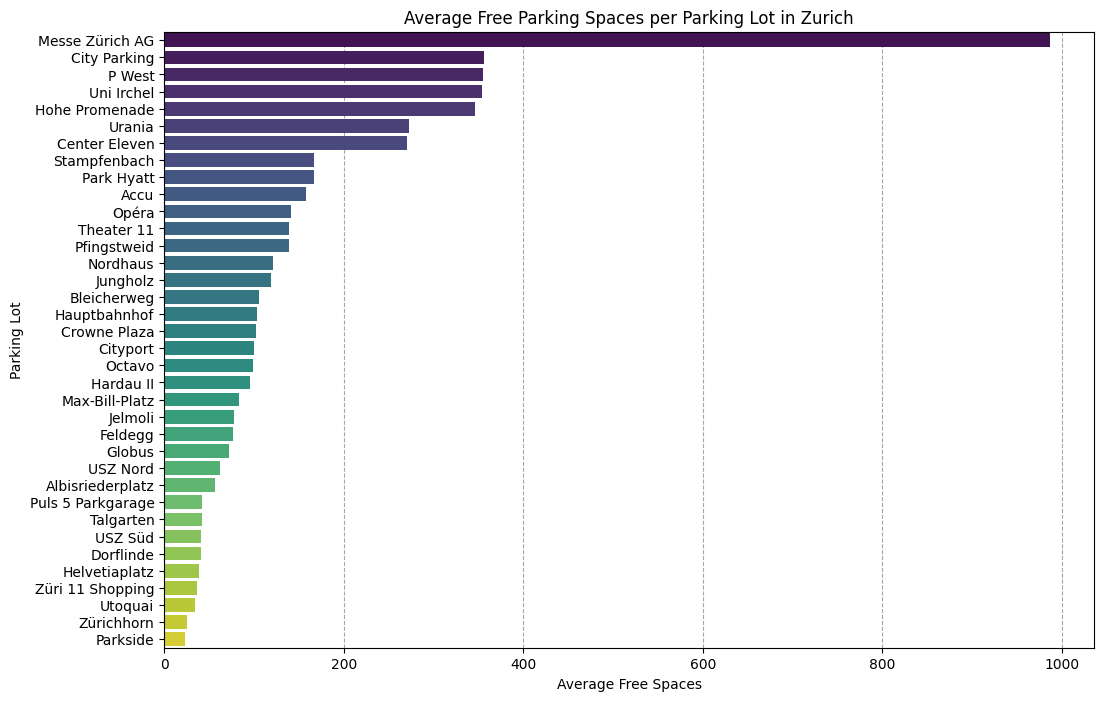

In [ ]:
# Load Zurich cleaned data
df_zurich = pd.read_csv("parkhaus_data_2024_zurich_cleaned.csv")

# Group data by lot_id and lot_name to calculate the average free spaces per parking lot
avg_free_by_lot = df_zurich.groupby(['lot_id', 'lot_name'])['free'].mean().reset_index()
avg_free_by_lot.rename(columns={'free': 'avg_free'}, inplace=True)

# Optional: Sort the results by average free spaces (descending order)
avg_free_by_lot.sort_values(by='avg_free', ascending=False, inplace=True)
print(avg_free_by_lot)

# Visualize the average free spaces per parking lot using a bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='avg_free', y='lot_name', data=avg_free_by_lot, palette="viridis")
plt.title("Average Free Parking Spaces per Parking Lot in Zurich")
plt.xlabel("Average Free Spaces")
plt.ylabel("Parking Lot")

# Add vertical grid lines for better readability
plt.gca().set_axisbelow(True)  # ensure grid lines are behind the bars
plt.grid(axis='x', color='gray', linestyle='--', alpha=0.7)

plt.show()


This bar chart illustrates the average number of free parking spaces per parking lot in Zurich for the selected time period (2024). Each bar represents one parking facility, and the x-axis indicates how many spaces are free on average. The chart is sorted from highest to lowest availability, showing that some lots (e.g., Messe Zürich AG) have significantly more free spaces on average than others. These differences may stem from factors such as total capacity, location, or typical usage patterns.

### Time series of hourly aggregation

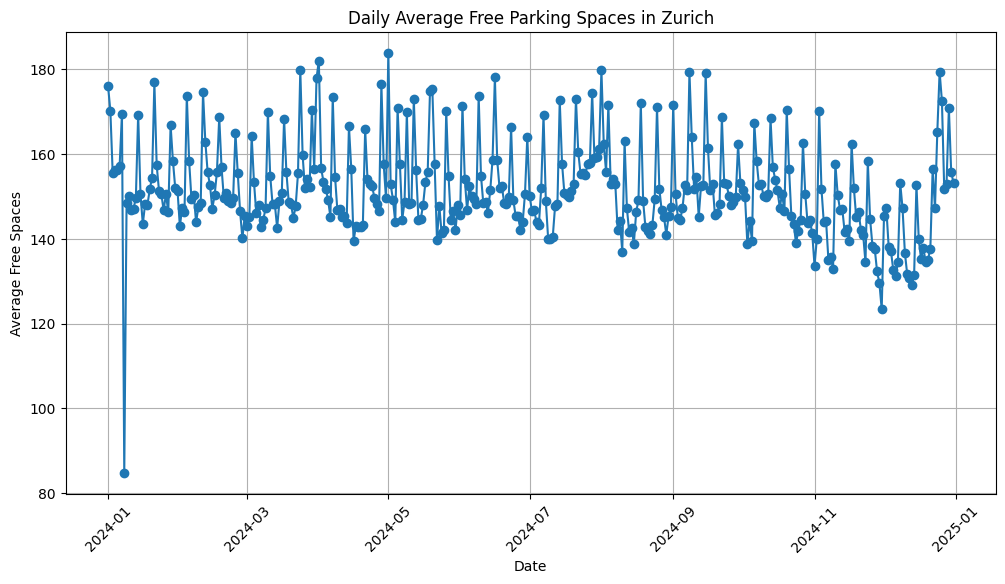

In [ ]:
# Load aggregated data from CSV files
df_daily = pd.read_csv("zurich_daily.csv")           # Daily averages
df_hourly = pd.read_csv("zurich_hourly.csv")           # Hourly averages with rolling average
df_weekday_hour = pd.read_csv("zurich_weekday_hour.csv")  # Grouped by weekday and hour

# Convert 'date' to datetime for proper plotting
df_daily['date'] = pd.to_datetime(df_daily['date'])
plt.figure(figsize=(12,6))
plt.plot(df_daily['date'], df_daily['avg_free'], marker='o', linestyle='-')
plt.title("Daily Average Free Parking Spaces in Zurich")
plt.xlabel("Date")
plt.ylabel("Average Free Spaces")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


This line chart shows the daily average number of free parking spaces in Zurich throughout 2024. Each data point represents the mean availability for a single day, providing an overview of how parking supply fluctuates over the year. Notably, there is a conspicuously low value at the very beginning of the year. This dip could indicate an anomaly in parking demand or supply (possibly due to special events, lower occupancy, or data issues) that warrants further investigation. The x-axis displays the date, while the y-axis shows the average free spaces.

### Weekdays vs Weekends

#### Boxplot

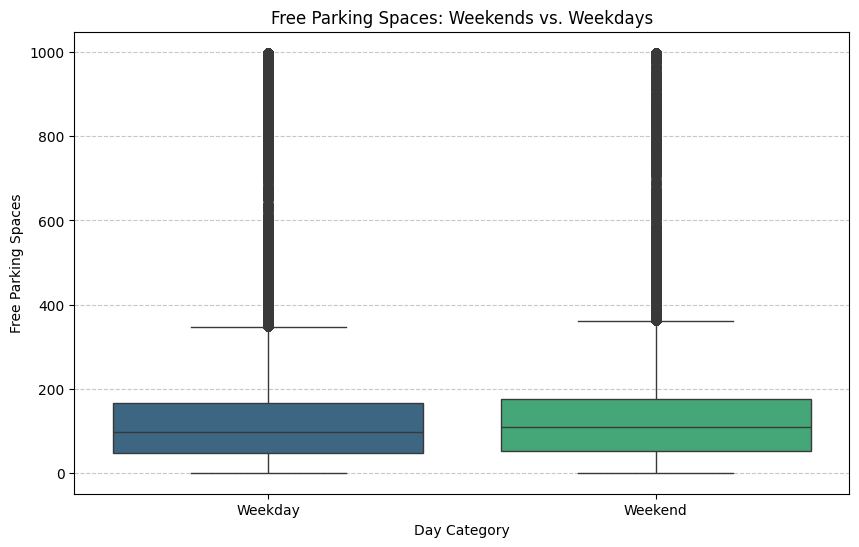

In [ ]:
# Load Zurich cleaned data
df_zurich = pd.read_csv("parkhaus_data_2024_zurich_cleaned.csv")
df_zurich['timestamp'] = pd.to_datetime(df_zurich['timestamp'], errors='coerce')

# Ensure the 'weekday' column exists
if 'weekday' not in df_zurich.columns:
    df_zurich['weekday'] = df_zurich['timestamp'].dt.day_name()

# Create a column 'is_weekend': True if Saturday or Sunday, False otherwise
df_zurich['is_weekend'] = df_zurich['weekday'].isin(['Saturday', 'Sunday'])

# Create a textual category column for the x-axis
df_zurich['weekend_category'] = np.where(df_zurich['is_weekend'], 'Weekend', 'Weekday')

plt.figure(figsize=(10,6))

# Create a static boxplot with hue set to the same variable as x
sns.boxplot(x='weekend_category', 
            y='free', 
            data=df_zurich, 
            hue='weekend_category', 
            palette='viridis', 
            showmeans=False, 
            dodge=False)

# Remove the redundant legend
plt.legend([], [], frameon=False)

plt.title("Free Parking Spaces: Weekends vs. Weekdays")
plt.xlabel("Day Category")
plt.ylabel("Free Parking Spaces")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


This boxplot compares free parking spaces on weekdays (left) versus weekends (right). Each box shows the middle 50 % of the data (the interquartile range), while the horizontal line indicates the median. Whiskers represent the majority of the remaining data points, and any values beyond them are considered outliers. At a glance, the distribution for weekdays appears slightly lower, suggesting fewer free spaces on weekdays than on weekends, though both categories display some high outliers.

#### Interactive barchart

In [ ]:
# Set the Plotly renderer (adjust as needed)
pio.renderers.default = 'browser'

# Load daily aggregated data (each row represents the daily average free spaces)
df_daily = pd.read_csv("zurich_daily.csv", parse_dates=['date'])

# Create a column for the day name
df_daily['weekday'] = df_daily['date'].dt.day_name()

# Classify each day as 'Weekday' or 'Weekend'
df_daily['day_type'] = df_daily['weekday'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

# Calculate the ISO week number for each date
df_daily['week'] = df_daily['date'].dt.isocalendar().week

# Group by week and day_type and calculate the average free spaces for each group
weekly_avg = df_daily.groupby(['week','day_type'])['avg_free'].mean().reset_index()

# Create a grouped bar chart (side-by-side bars) using Plotly Express
fig = px.bar(weekly_avg,
             x='week',
             y='avg_free',
             color='day_type',
             barmode='group',
             title="Weekly Average Free Parking Spaces: Weekdays vs. Weekends in Zurich",
             labels={'week': 'Week Number', 'avg_free': 'Average Free Spaces', 'day_type': 'Day Type'})

fig.show()


This grouped bar chart displays the weekly average free parking spaces in Zurich separated into two categories: one for weekdays (blue) and one for weekends (red). In most weeks, the blue bars (representing weekdays) tend to be slightly lower, indicating that there are marginally fewer free parking spaces available during the week compared to weekends. Each bar shows the average of the daily values for that week, allowing for an easy comparison of parking availability trends over the course of the year. This visualization helps identify subtle differences that may be influenced by factors such as seasonal changes, events, or holiday periods.

### Working hours vs border hours

#### Boxplot

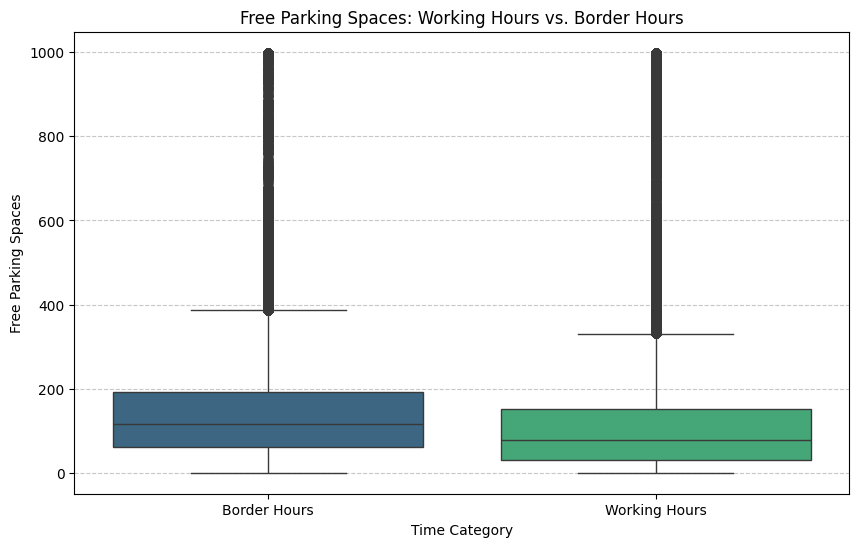

In [8]:
# Load Zurich cleaned data
df_zurich = pd.read_csv("parkhaus_data_2024_zurich_cleaned.csv")
df_zurich['timestamp'] = pd.to_datetime(df_zurich['timestamp'], errors='coerce')

# Ensure the 'hour' column exists
if 'hour' not in df_zurich.columns:
    df_zurich['hour'] = df_zurich['timestamp'].dt.hour

# Create the 'time_category' column if it doesn't exist:
# Working Hours: from 8:00 to 18:00, Border Hours: all other times.
if 'time_category' not in df_zurich.columns:
    df_zurich['time_category'] = np.where((df_zurich['hour'] >= 8) & (df_zurich['hour'] < 18),
                                          'Working Hours', 'Border Hours')

# Create a static boxplot for Working Hours vs. Border Hours using Seaborn
plt.figure(figsize=(10,6))
sns.boxplot(x='time_category', 
            y='free', 
            data=df_zurich, 
            hue='time_category',  # assign hue to the same variable as x
            palette="viridis", 
            dodge=False)         # use dodge=False so boxes don't separate
plt.legend([],[], frameon=False)  # remove the duplicate legend
plt.title("Free Parking Spaces: Working Hours vs. Border Hours")
plt.xlabel("Time Category")
plt.ylabel("Free Parking Spaces")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


This boxplot compares free parking spaces during Border Hours (all times outside 8:00–18:00) and Working Hours (8:00–18:00). Each box shows the middle 50% of the data (the interquartile range), the horizontal line in the box indicates the median, and the whiskers represent the data range excluding outliers (plotted as individual points).

From this visualization, we see that Border Hours typically have a higher median availability than Working Hours, though both categories exhibit high outliers indicating times or locations where many free spaces may be reported. The distribution helps identify whether parking demand is generally higher (i.e., fewer free spaces) during core business hours compared to the rest of the day.

#### Interactive barchart

In [ ]:
# Set the Plotly renderer (adjust as needed)
pio.renderers.default = 'browser'

# Load hourly aggregated data (each row represents the hourly average free spaces)
df_hourly = pd.read_csv("zurich_hourly.csv", parse_dates=['timestamp_hour'])

# Create an 'hour' column from the timestamp if not already present
df_hourly['hour'] = df_hourly['timestamp_hour'].dt.hour

# Classify each hour as 'Working Hours' (8:00 to 18:00) or 'Border Hours' (all other times)
df_hourly['time_category'] = df_hourly['hour'].apply(lambda x: 'Working Hours' if 8 <= x < 18 else 'Border Hours')

# Calculate the ISO week number for each timestamp
df_hourly['week'] = df_hourly['timestamp_hour'].dt.isocalendar().week

# Group by week and time_category, calculating the average free spaces per group
weekly_avg_time = df_hourly.groupby(['week', 'time_category'])['avg_free'].mean().reset_index()

# Create a grouped bar chart (side-by-side bars) using Plotly Express
fig = px.bar(weekly_avg_time,
             x='week',
             y='avg_free',
             color='time_category',
             barmode='group',
             title="Weekly Average Free Parking Spaces: Working vs. Border Hours in Zurich",
             labels={'week': 'Week Number', 'avg_free': 'Average Free Spaces', 'time_category': 'Time Category'})

fig.show()


This grouped bar chart displays the weekly average free parking spaces in Zurich, comparing two time categories: Working Hours (from 8:00 to 18:00) and Border Hours (all other times). For each week, two separate bars are shown side by side, one for each time category. This visualization highlights that, in most weeks, the average number of free spaces during Working Hours is lower than during Border Hours—indicating a higher parking demand during typical business hours. The chart allows for an easy, week-by-week comparison of parking availability between these two time periods.



### Comparison of season

#### Boxplot

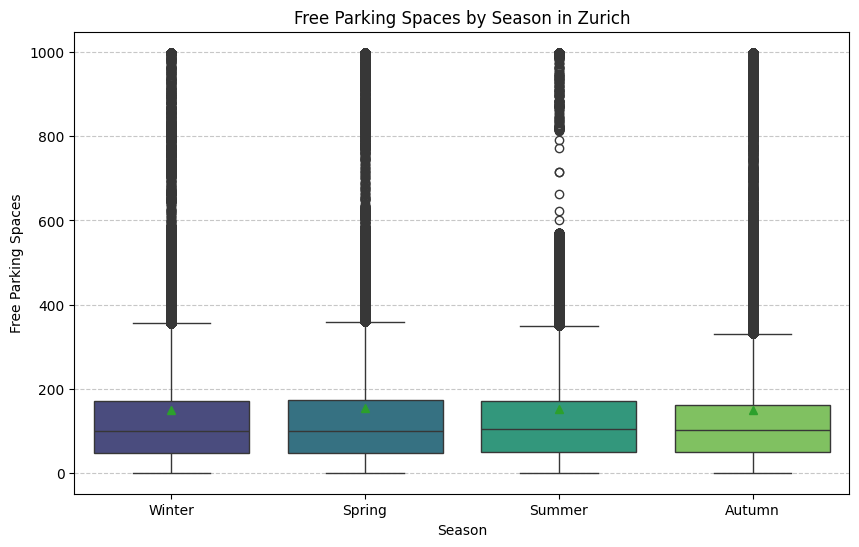

In [ ]:
# Create a static boxplot to compare free parking spaces by season
plt.figure(figsize=(10,6))
sns.boxplot(x='season', 
            y='free', 
            data=df_zurich, 
            order=['Winter', 'Spring', 'Summer', 'Autumn'], 
            hue='season', 
            palette='viridis', 
            showmeans=True, 
            dodge=False)
plt.legend([], [], frameon=False)  # Remove the redundant legend
plt.title("Free Parking Spaces by Season in Zurich")
plt.xlabel("Season")
plt.ylabel("Free Parking Spaces")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


This boxplot displays free parking spaces in Zurich across four seasons. In Winter, the median is on the lower side with a compact spread, indicating stable availability. Spring shows a slight increase in the median and a bit more variability. Summer’s box has a similar median to Spring but includes several high outliers, suggesting that parking availability can spike on certain days. Finally, Autumn presents a moderate median with a relatively narrow spread. Overall, while the medians are similar, Summer exhibits greater variability compared to the other seasons.

## Zurich vs Basel

### Dual Axis

In [28]:
# Load Zurich daily data (should contain 'date' and 'avg_free')
df_zurich = pd.read_csv("zurich_daily.csv", parse_dates=['date'])

# Load Basel cleaned data (should contain 'timestamp' and 'Anzahl frei')
df_basel = pd.read_csv("parkhaus_data_2024_basel_cleaned.csv")

# Convert 'timestamp' to datetime format
df_basel['timestamp'] = pd.to_datetime(df_basel['timestamp'], errors='coerce')

# If the column 'free' is not present, rename 'Anzahl frei' to 'free'
if 'free' not in df_basel.columns:
    df_basel.rename(columns={'Anzahl frei': 'free'}, inplace=True)

# Create a 'date' column by extracting the date from 'timestamp'
df_basel['date'] = pd.to_datetime(df_basel['timestamp'].dt.date)

# Aggregate daily free parking spaces for Basel
df_basel_daily = df_basel.groupby('date')['free'].mean().reset_index()
df_basel_daily.rename(columns={'free': 'avg_free'}, inplace=True)

print("Basel daily data preview:")
print(df_basel_daily.head())

# Create a dual-axis line chart
fig = go.Figure()

# Add Zurich trace (primary y-axis)
fig.add_trace(go.Scatter(
    x=df_zurich['date'],
    y=df_zurich['avg_free'],
    mode='lines+markers',
    name='Zurich',
    line=dict(color='blue')
))

# Add Basel trace (secondary y-axis)
fig.add_trace(go.Scatter(
    x=df_basel_daily['date'],
    y=df_basel_daily['avg_free'],
    mode='lines+markers',
    name='Basel',
    line=dict(color='red'),
    yaxis='y2'
))

# Update layout for dual-axis display using proper title settings
fig.update_layout(
    title="Daily Average Free Parking Spaces: Zurich vs. Basel",
    xaxis=dict(title="Date"),
    yaxis=dict(
        title=dict(text="Zurich Free Spaces", font=dict(color='blue')),
        tickfont=dict(color='blue')
    ),
    yaxis2=dict(
        title=dict(text="Basel Free Spaces", font=dict(color='red')),
        tickfont=dict(color='red'),
        overlaying="y",
        side="right"
    ),
    legend=dict(x=0.01, y=0.99)
)

fig.show()


Basel daily data preview:
        date    avg_free
0 2024-01-01  266.182065
1 2024-01-02  236.132812
2 2024-01-03  225.708333
3 2024-01-04  225.593750
4 2024-01-05  229.335938


This dual‐axis line chart compares the daily average free parking spaces in Zurich (blue, left axis) and Basel (red, right axis) throughout 2024. Each marker represents a single day's average availability for the respective city. The separate y-axes ensure that any differences in scale between Zurich and Basel do not obscure the comparison. By hovering over the interactive chart, you can inspect exact values and spot trends—such as periods where one city has consistently more free parking spaces than the other, or times when both cities show similar patterns, possibly indicating shared influences (e.g., holidays, seasonal events).

### Interactive Dashboard

In [36]:
# Load the daily aggregated data for Zurich and Basel
df_zurich = pd.read_csv("zurich_daily.csv", parse_dates=['date'])
df_basel = pd.read_csv("parkhaus_data_2024_basel_daily.csv", parse_dates=['date'])

# Function to create the dual-axis figure based on a date range
def create_dual_axis_figure(start_date, end_date):
    # Filter data based on the selected date range
    mask_z = (df_zurich['date'] >= start_date) & (df_zurich['date'] <= end_date)
    mask_b = (df_basel['date'] >= start_date) & (df_basel['date'] <= end_date)
    d_z = df_zurich.loc[mask_z]
    d_b = df_basel.loc[mask_b]
    
    fig = go.Figure()
    
    # Add Zurich trace (primary y-axis)
    fig.add_trace(go.Scatter(
        x=d_z['date'],
        y=d_z['avg_free'],
        mode='lines+markers',
        name='Zurich',
        line=dict(color='blue')
    ))
    
    # Add Basel trace (secondary y-axis)
    fig.add_trace(go.Scatter(
        x=d_b['date'],
        y=d_b['avg_free'],
        mode='lines+markers',
        name='Basel',
        line=dict(color='red'),
        yaxis='y2'
    ))
    
    # Update layout for dual-axis display
    fig.update_layout(
        title="Daily Average Free Parking Spaces: Zurich vs. Basel",
        xaxis=dict(title="Date"),
        yaxis=dict(
            title=dict(text="Zurich Free Spaces", font=dict(color='blue')),
            tickfont=dict(color='blue')
        ),
        yaxis2=dict(
            title=dict(text="Basel Free Spaces", font=dict(color='red')),
            tickfont=dict(color='red'),
            overlaying="y",
            side="right"
        ),
        legend=dict(x=0.01, y=0.99)
    )
    return fig

# Initialize the Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Parking Availability Dashboard"),
    html.Div([
        html.Label("Select Date Range:"),
        dcc.DatePickerRange(
            id='date-range',
            min_date_allowed=df_zurich['date'].min(),
            max_date_allowed=df_zurich['date'].max(),
            start_date=df_zurich['date'].min(),
            end_date=df_zurich['date'].max()
        )
    ], style={'margin': '20px'}),
    dcc.Graph(id='dual-axis-plot')
])

# Callback to update the graph based on the selected date range
@app.callback(
    Output('dual-axis-plot', 'figure'),
    [Input('date-range', 'start_date'),
     Input('date-range', 'end_date')]
)
def update_figure(start_date, end_date):
    fig = create_dual_axis_figure(start_date, end_date)
    return fig

if __name__ == '__main__':
    app.run(debug=True)


In [ ]:
# Group data by time_category and calculate the average free spaces
avg_time_category = df_zurich.groupby('time_category')['free'].mean().reset_index()

# Create an interactive grouped bar chart
fig = px.bar(avg_time_category,
             x='time_category',
             y='free',
             title="Average Free Parking Spaces: Working Hours vs. Border Hours",
             labels={'time_category': 'Time Category', 'free': 'Average Free Parking Spaces'},
             color='time_category')
fig.show()


In [ ]:
import matplotlib.pyplot as plt

# Convert the 'timestamp' column to datetime
df_parkhaus_data_2024_zurich['timestamp'] = pd.to_datetime(df_parkhaus_data_2024['timestamp'])

# Set the 'timestamp' column as the index
df_parkhaus_data_2024_zurich.set_index('timestamp', inplace=True)

# Plot the time series data
df_parkhaus_data_2024_zurich['free'].plot(figsize=(15, 5), title='Free Parking Spaces Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Free Parking Spaces')
plt.show()


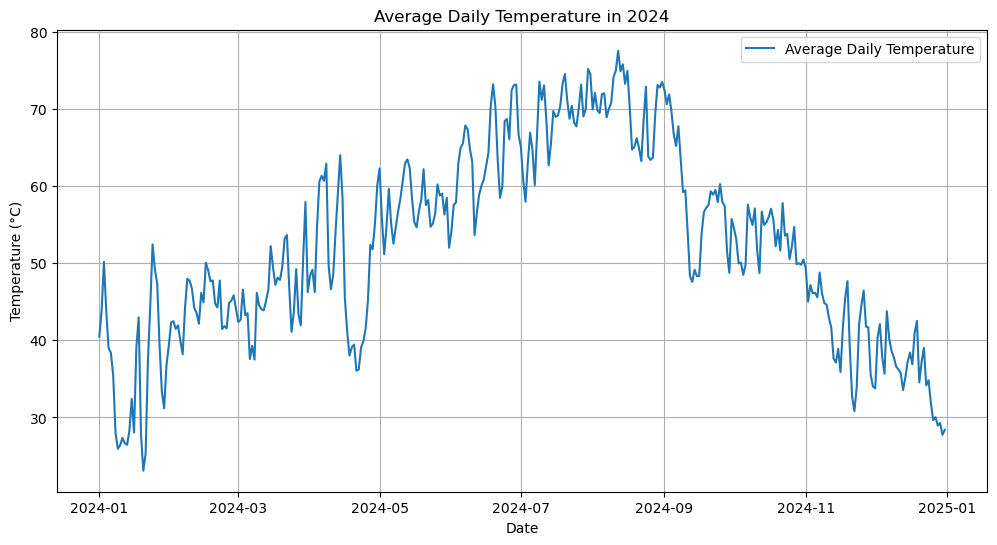

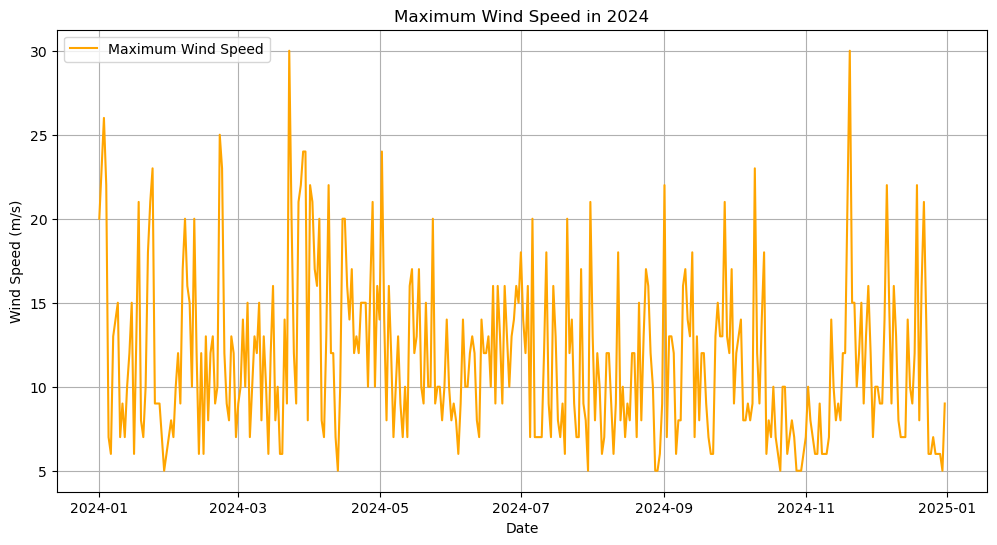

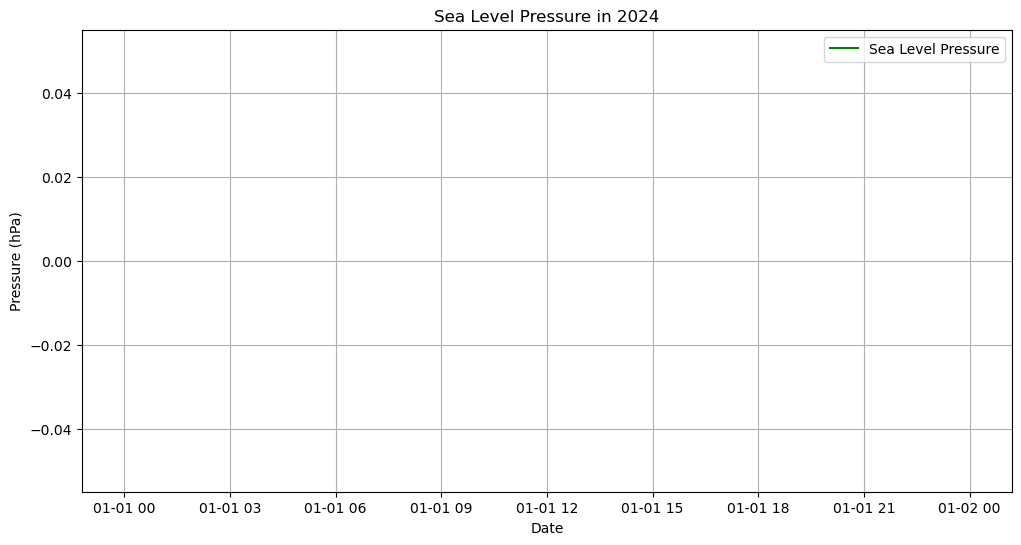

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt

# Load the weather data from the CSV file
df_weather_2024 = pd.read_csv("weather_2024_lszh.csv")

# Convert the 'date' column to datetime objects
df_weather_2024['date'] = pd.to_datetime(df_weather_2024['date'])

# Set 'date' as the index of the DataFrame
df_weather_2024.set_index('date', inplace=True)

# Plotting the average daily temperature
plt.figure(figsize=(12, 6))
plt.plot(df_weather_2024['day_avg_temp'], label='Average Daily Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Average Daily Temperature in 2024')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the maximum wind speed
plt.figure(figsize=(12, 6))
plt.plot(df_weather_2024['max_wind_speed'], label='Maximum Wind Speed', color='orange')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.title('Maximum Wind Speed in 2024')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the sea level pressure
plt.figure(figsize=(12, 6))
plt.plot(df_weather_2024['sea_level_pressure'], label='Sea Level Pressure', color='green')
plt.xlabel('Date')
plt.ylabel('Pressure (hPa)')
plt.title('Sea Level Pressure in 2024')
plt.legend()
plt.grid(True)
plt.show()


# Model Analysis

Model Performance Metrics:
Mean Squared Error: 20.59
R² Score: -0.15


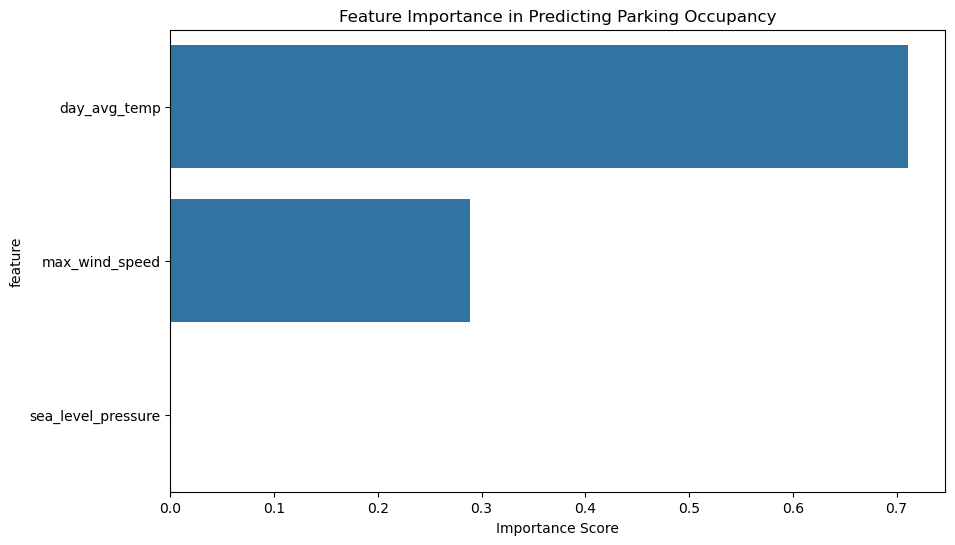

In [ ]:
from src.models.parking_occupancy_model import prepare_data, train_model
import seaborn as sns

# Prepare and train the model
X, y = prepare_data()
model, mse, r2, X_test, y_test, y_pred = train_model(X, y)

print(f"Model Performance Metrics:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Predicting Parking Occupancy')
plt.xlabel('Importance Score')
plt.show()


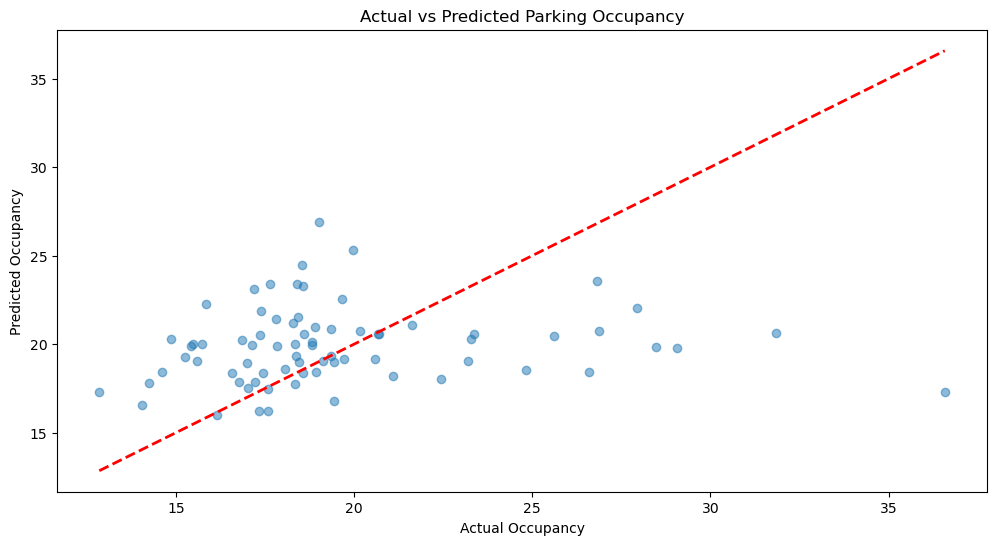

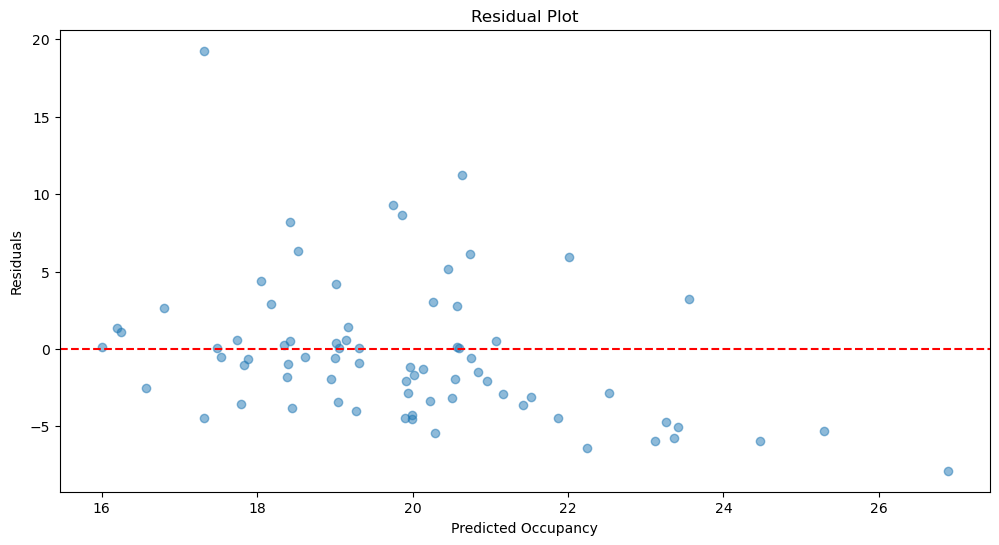

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Occupancy')
plt.ylabel('Predicted Occupancy')
plt.title('Actual vs Predicted Parking Occupancy')
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Occupancy')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


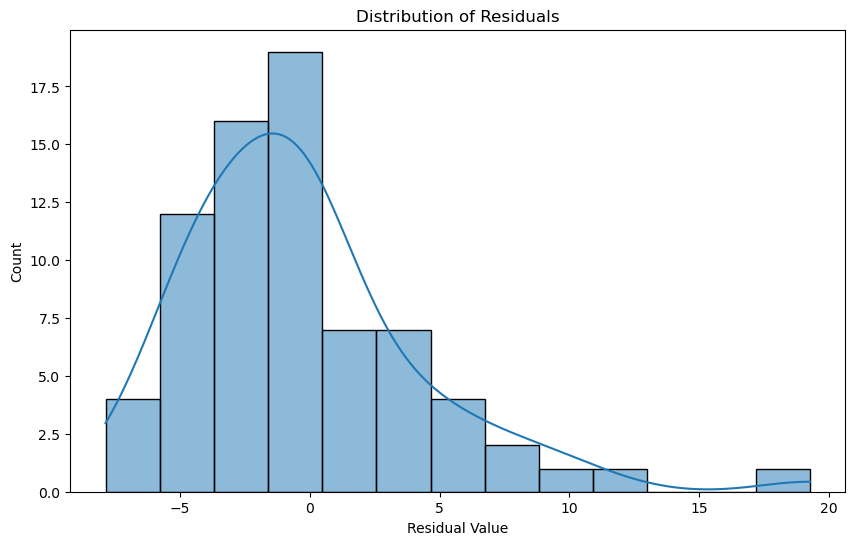

<Figure size 1500x600 with 0 Axes>

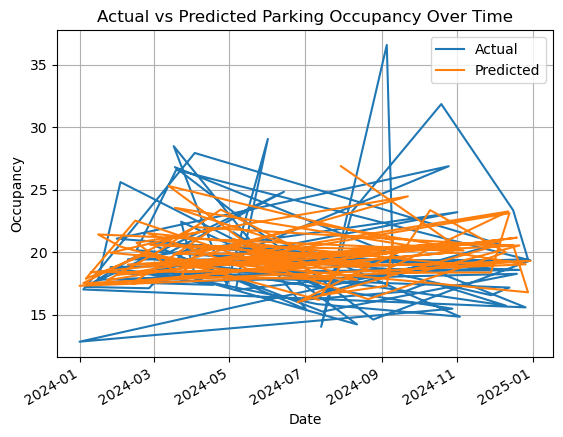

In [ ]:
# Distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.show()

# Prediction over time
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
}, index=X_test.index)

plt.figure(figsize=(15, 6))
results_df.plot()
plt.title('Actual vs Predicted Parking Occupancy Over Time')
plt.xlabel('Date')
plt.ylabel('Occupancy')
plt.legend()
plt.grid(True)
plt.show()
